# Tutorial 1.1: Pattern search-based two level optimization

- **Authors**: Xiaoyu Xie
- **Contact**: xiaoyuxie2020@u.northwestern.edu

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiaoyuxie-vico/PyDimension-Book/blob/main/examples/pattern_search.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/xiaoyuxie-vico/PyDimension-Book/HEAD)

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

%matplotlib inline
# plt.rcParams["font.family"] = 'Arial'
np.set_printoptions(suppress=True)


In [2]:
# # please uncomment these two lines, if you run this code in Colab
# !git clone https://github.com/xiaoyuxie-vico/PyDimension-Book
# %cd PyDimension-Book/examples

## Helper functions

In [3]:
class Dataset(object):
    '''
    Load and parse dataset
    '''

    def __init__(self, dataset_path, input_list, output_list):
        self.dataset_path = dataset_path
        self.input_list, self.output_list = input_list, output_list

        self.df = self._load_dataset()
        self.df_train, self.df_test = self._split_dataset()

    def _load_dataset(self):
        '''load dataset'''
        df = pd.read_csv(self.dataset_path)
        return df
    
    def _split_dataset(self, test_size=0.2, random_state=1):
        '''randomly split dataset'''
        df_train, df_test = train_test_split(self.df, test_size=test_size, random_state=random_state)
        return df_train, df_test

    def parser(self, is_shuffle=True, random_state=0):
        '''load dataset using numpy'''
        X_train = self.df_train[self.input_list].to_numpy()
        y_train = self.df_train[self.output_list].to_numpy().reshape(-1,)

        X_test = self.df_test[self.input_list].to_numpy()
        y_test = self.df_test[self.output_list].to_numpy().reshape(-1,)

        # shuffle
        X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

        return X_train, y_train, X_test, y_test


dataset_path = '../dataset/dataset_keyhole.csv'
input_list = ['etaP', 'Vs', 'r0', 'alpha', 'rho', 'cp', 'Tl-T0']
output_list = ['e*']

data_loader = Dataset(dataset_path, input_list, output_list)
X_train, y_train, X_test, y_test = data_loader.parser()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(72, 7) (72,) (18, 7) (18,)


In [4]:

class DimensionlessLearning(object):
    '''
    Indentify the explicit form one coefficient using dimensionless learning
    '''
    def __init__(self, X, y, scaling_mat):
        super(DimensionlessLearning, self).__init__()
        self.X, self.y = X, y
        self.scaling_mat = scaling_mat
        self.basis_num = scaling_mat.shape[1]

    def parse_power_index(self, basis_coef):
        '''
        parse power index based on basis coefficients
        '''
        power_index = np.sum(np.multiply(self.scaling_mat, basis_coef), axis=1)
        return power_index

    def scale_input(self, X, basis_coef):
        '''
        scale the the input data into a few dimensionless numbers
        '''
        power_index = self.parse_power_index(basis_coef)
        X_scaled = np.prod(np.power(X, power_index), axis=1)
        return X_scaled, power_index

    def parse_feats(self, X, deg=5):
        '''
        prepare different degrees' features
        '''
        poly = PolynomialFeatures(deg)
        X_poly = poly.fit_transform(X.reshape(-1, 1))
        return X_poly

    def predict(self, X, power_index, scaling_coef, deg=5):
        '''
        based on learned basis coefficients and scaling coefficients to predict
        '''
        X_scaled = np.prod(np.power(X, power_index), axis=1)
        X_poly = self.parse_feats(X_scaled, deg)
        pred = np.sum(np.multiply(X_poly, scaling_coef), axis=1)
        return pred

    def fit(self, method='pattern_search', init_point_num=20, seed=0):
        '''
        fit the data
        '''
        BASE = 2 ** 20
        r2, basis_coef, scaling_coef = 0, None, None
        
        for idx in range(init_point_num):
            seed = (idx + seed * init_point_num) % BASE

            if method == 'pattern_search':
                r2_temp, basis_coef_temp, scaling_coef_temp = self.fit_pattern_search(seed=seed)
            elif method == 'gradient_descent':
                r2_temp, basis_coef_temp, scaling_coef_temp = self.fit_gradient_descent(seed=seed)
                print('r2_temp, basis_coef_temp, scaling_coef_temp', r2_temp, basis_coef_temp, scaling_coef_temp)
            else:
                raise Exception('Error in the optimizaiton method')

            if r2_temp < r2:
                continue
            r2, basis_coef, scaling_coef = r2_temp, basis_coef_temp, scaling_coef_temp

        return r2, basis_coef, scaling_coef

    def _opt(self, basis_coef):
        '''
        fit a linear regression
        '''
        # prepare polynomial features based on dimensionless numbers
        X_scaled, power_index = self.scale_input(self.X, basis_coef)
        X_poly = self.parse_feats(X_scaled)

        # fit a polynomial
        reg = LinearRegression(fit_intercept=False)
        reg.fit(X_poly, self.y)
        y_pred = reg.predict(X_poly)
        r2 = r2_score(self.y, y_pred)
        scaling_coef = reg.coef_

        return r2, power_index, scaling_coef

    def fit_pattern_search(self, gamma0=0.5, max_iter=10, grid_range=[-2, 2], grid_interval=0.5, clip_threshold=0.2, seed=0):
        '''
        pattern search-based optimization

        Args:
            gamma0 [float]: basis coefficient for the first basis vector;
            max_iter [int]: the maximum iteration for pattern search;
            grid_range [list of int]: the range for each basis coefficient;
            grid_interval [float]: the grid interval for each basis coefficient;
            clip_threshold [float]: if the R2 score for the initial point is lower than this threshold, break the loop;
        Return:
            r2 [float]: the final R2 score
            power_index [array]: the power law index for one input dimensionless nunber
            scaling_coef [array]: the scaling law coefficients
        '''
        def _get_coordinates(basis_num, basis_coef, grid_interval):
            '''
            build a list to store all possible coordiantes
            '''
            # prepare grid
            param_grid = {}
            center_coord = []
            coord_all = []
            for i in range(basis_num):
                gamma_value = basis_coef[i]
                param_grid[f'gamma{i}'] = [gamma_value-grid_interval, gamma_value, gamma_value+grid_interval]
                center_coord.append(gamma_value)
            
            # build grid
            grid = ParameterGrid(param_grid)
            for params in grid:
                coord = []
                for i in range(basis_num):
                    coord.append(params[f'gamma{i}'])
                if coord != center_coord:
                    coord_all.append(coord)
            return coord_all

        def _init_basis_coef(basis_num, grid_range, grid_interval, gamma0):
            '''
            initialize basis coefficient
            '''
            grid_num = int((grid_range[1] - grid_range[0]) / grid_interval + 1)
            basis_coef = np.zeros((basis_num))
            for i in range(basis_num):
                basis_coef[i] = np.random.choice(np.linspace(grid_range[0], grid_range[1], grid_num), 1)[0]  # [-2, 2]
                # basis_coef[i] = 1
            basis_coef[0] = gamma0
            return basis_coef

        # initial basis coefficients
        np.random.seed(seed)
        basis_coef = _init_basis_coef(self.basis_num, grid_range, grid_interval, gamma0)

        # randomly initialize different center points
        iter_num = 0
        while iter_num < max_iter:
            candidate_coord = _get_coordinates(self.basis_num, basis_coef, grid_interval)
            # calculate the center point
            r2_center, power_index_center, scaling_coef_center = self._opt(basis_coef)
            # print('r2_center', round(r2_center, 4), 'power_index_center', [round(each, 2) for each in list(power_index_center.reshape(-1,))])

            # break if the initial point has a low R2 score
            if r2_center < clip_threshold:
                break
            
            # calculate the neighboring points
            r2_bounds_val = []
            for gamma_list in candidate_coord:
                basis_coef_temp = np.array(gamma_list)
                r2_bound, power_index_bound, scaling_coef_bound = self._opt(basis_coef_temp)
                r2_bounds_val.append(r2_bound)

            # sort the R2 score for neighboring points from high to low
            highest_index = np.argsort(r2_bounds_val)[::-1][0]
            iter_num += 1

            # udpate the center coordiantes if the neighboring point has a higher R2 score
            if r2_center < r2_bounds_val[highest_index]:
                basis_coef = np.array(candidate_coord[highest_index])
                power_index = self.parse_power_index(basis_coef)
                # res_info = {'gamma_list': gamma_list, 'r2_center': round(r2_bounds_val[highest_index], 4)}
            else:
                break

        # calcualte the final R2 and coefficients
        r2, power_index, scaling_coef = self._opt(basis_coef)

        return r2, power_index, scaling_coef

[Dataset] X_train: (72, 7), y_train: (72,)
[Dataset] X_test: (18, 7), y_test: (18,)
[Training]


Final r2: 0.9841, power_index: [ 1.  -0.5 -1.5 -0.5 -1.  -1.  -1. ], scaling_coef: [-0.14717067  0.06325514  0.0038886  -0.00009134  0.00000091 -0.        ]
[Visualization]


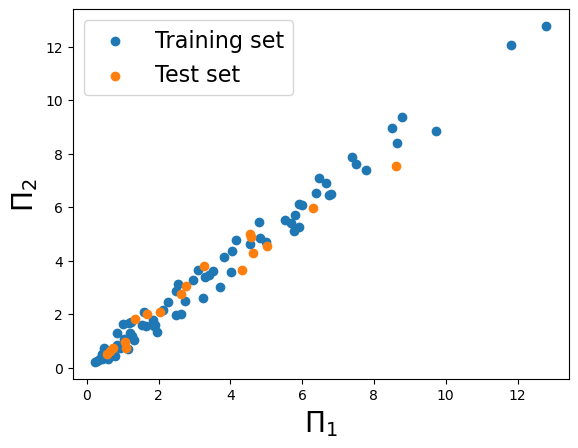

In [5]:
def test_keyhole_example(method):
    '''
    keyhole problem
    '''
    ################################### config ###################################
    dataset_path = '../dataset/dataset_keyhole.csv'
    input_list = ['etaP', 'Vs', 'r0', 'alpha', 'rho', 'cp', 'Tl-T0']
    output_list = ['e*']
    
    # dimension matrix
    D_in = np.array(
        [
            [2., 1., 1., 2., -3., 2., 0.],
            [-3., -1., 0., -1., 0., -2., 0.],
            [1., 0., 0., 0., 1., 0., 0.],
            [0., 0., 0., 0., 0., -1., 1.],
        ],
    )

    # best weights for Ke: 0.5, 1, 1
    # basis vectors in columns
    scaling_mat = np.array(
        [
            [0., 0., 1],
            [1, 2., -3],
            [1, 0., -2.],
            [-1, 0., 0.],
            [0., 0., -1],
            [0., -1, 0.],
            [0., -1, 0.]],
    )
    deg = 5

    ################################### dataset ########################################
    # load, split, and shuffle the dataset
    data_loader = Dataset(dataset_path, input_list, output_list)
    X_train, y_train, X_test, y_test = data_loader.parser()
    print(f'[Dataset] X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'[Dataset] X_test: {X_test.shape}, y_test: {y_test.shape}')

    ################################### training and testing ###########################
    print('[Training]')
    dimensionless_learning = DimensionlessLearning(X_train, y_train, scaling_mat)
    r2, power_index, scaling_coef = dimensionless_learning.fit(method=method)
    print(f'Final r2: {r2:.4f}, power_index: {power_index}, scaling_coef: {scaling_coef}')
    pred_train = dimensionless_learning.predict(X_train, power_index, scaling_coef, deg)
    pred_test = dimensionless_learning.predict(X_test, power_index, scaling_coef, deg)

    ################################### visualization ###################################
    print('[Visualization]')
    fig = plt.figure()
    plt.scatter(pred_train, y_train, label='Training set')
    plt.scatter(pred_test, y_test, label='Test set')
    plt.legend(fontsize=16)
    plt.xlabel(r'$\Pi_1$', fontsize=20)
    plt.ylabel(r'$\Pi_2$', fontsize=20)
    plt.show()


method = 'pattern_search'
test_keyhole_example(method)
